In [1]:
# Get mnist data
# Use morphomnist to plot the intensity
# Choose a distribution

In [2]:
# This path should get us to the root dir of the project
ROOT_PATH = '../../../'
MNIST_DATA_PATH = ROOT_PATH + 'assets/data/morphomnist/'
DATA_ZIP = 'train-images-idx3-ubyte.gz'

In [3]:
%matplotlib inline
import sys
import os
import multiprocessing

import pyro
import torch
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

sys.path.append(ROOT_PATH)

In [4]:
if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

In [5]:
from deepscm.morphomnist.io import load_idx

In [6]:
def get_intensity(img):
    threshold = 0.5

    img_min, img_max = img.min(), img.max()
    mask = (img >= img_min + (img_max - img_min) * threshold)
    avg_intensity = np.median(img[mask])

    return avg_intensity

In [7]:
int_thick_data = pd.read_csv(MNIST_DATA_PATH + 'train-morpho.csv', index_col='index')

labels = load_idx(MNIST_DATA_PATH + 'train-labels-idx1-ubyte.gz')
labels_df = pd.DataFrame(labels, columns=['label'])

morphology_data = pd.merge(int_thick_data, labels_df, left_index=True, right_index=True)
morphology_data.head()

,thickness,intensity,label
index,,,
0,2.398951,162.27393,5
1,2.789006,171.67532,0
2,2.655154,206.75359,4
3,2.852611,210.85230,1
4,1.750898,119.96817,9


In [8]:
morphology_data.label.value_counts()

1    6742
7    6265
3    6131
2    5958
9    5949
0    5923
6    5918
8    5851
4    5842
5    5421
Name: label, dtype: int64

<Figure size 720x720 with 0 Axes>

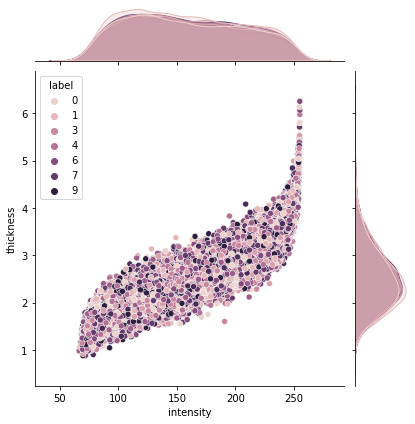

In [9]:
plt.figure(figsize=(10, 10))

sns.jointplot(data=morphology_data, x="intensity", y="thickness", hue="label")
plt.show()

<Figure size 720x720 with 0 Axes>

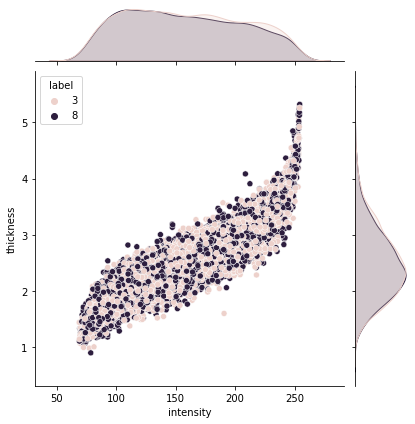

In [10]:
plt.figure(figsize=(10, 10))

sns.jointplot(data=morphology_data[morphology_data.label.isin([3, 8])], x="intensity", y="thickness", hue="label")
plt.show()

<Figure size 720x720 with 0 Axes>

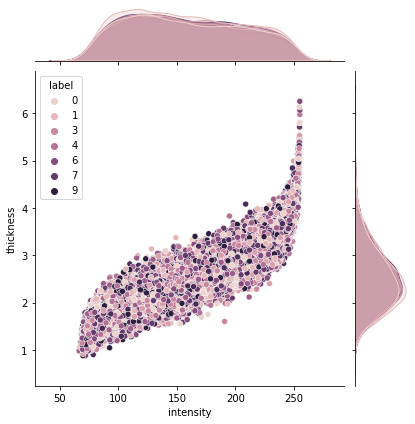

In [11]:
plt.figure(figsize=(10, 10))

sns.jointplot(data=morphology_data, x="intensity", y="thickness", hue="label")
plt.show()

In [12]:
morphology_data.intensity.describe()

count    60000.000000
mean       158.015839
std         48.379701
min         66.601204
25%        117.041938
50%        154.245835
75%        197.563997
max        254.903170
Name: intensity, dtype: float64

In [13]:
64 + 191

255

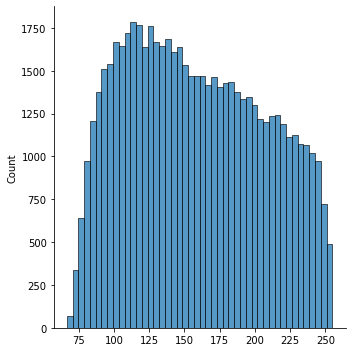

In [14]:
intensities = morphology_data.intensity.to_numpy()
sns.displot(intensities)
plt.show()

In [15]:
upper = intensities.max() - intensities.min()
lower = intensities.min()
upper, lower

(188.301966, 66.601204)

In [16]:
z = np.log((190 / (intensities - 66)) - 1)
loc = z.mean()
scale = z.var()

In [17]:
loc, scale

(0.049305123027108086, 1.8374342091632498)

In [18]:
from pyro.distributions import Normal, Gamma

In [19]:
with pyro.plate('intensity_observations', 60000):
    norm = Normal(0, 1)
    gam = Gamma(10, 5)
    z = pyro.sample('x', norm)
    y = pyro.sample('y', gam)
    
yy = 0.5 * z + 2 * y - 4

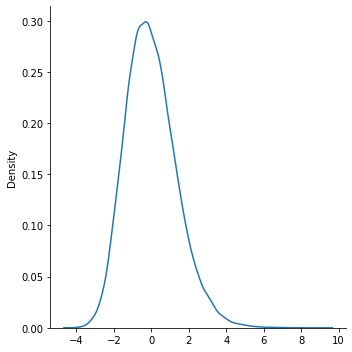

In [20]:
sns.displot(yy, kind="kde")

## Find parameters for the true data generating process of Intensity

In [21]:
import pyro

from pyro.distributions import Categorical, Normal, Gamma, TransformedDistribution, constraints, LogisticNormal
from pyro.distributions.transforms import SigmoidTransform, AffineTransform, ComposeTransform, ExpTransform
from pyro.infer import SVI

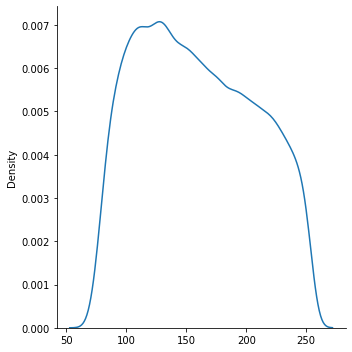

In [22]:
import torch
from torch.distributions import constraints


def intensity_dist(n_samples=60000):
    with pyro.plate('intensity_observations', n_samples):
        transforms = ComposeTransform([
            SigmoidTransform(),
            AffineTransform(66., 190.)]
        )
        
        noise1 = Normal(0, 1)
        noise2 = Gamma(10, 5)
        noise1_sample = pyro.sample('noise1', norm)
        noise2_sample = pyro.sample('noise2', gam)
        noise_rv = 0.5 * noise1_sample + 2 * noise2_sample - 4
        
    return transforms(noise_rv)
    # transformed_normal = TransformedDistribution(noise_rv, transforms)
    # intensity = pyro.sample("intensity", transformed_normal)
    # return intensity

intensity_samples = intensity_dist(60000)
sns.displot(intensity_samples, kind='kde')
plt.show()

In [23]:
transforms = ComposeTransform([SigmoidTransform(), AffineTransform(66., 190.)])
flow_dist = TransformedDistribution(Normal(-0.15, 1.3), transforms)

In [24]:
def intensity_dist_prior(X):
    mu = torch.Tensor(-0.15)
    sigma = torch.Tensor(1.3)
    with pyro.plate('intensity_observations', len(X)):
        transforms = ComposeTransform([SigmoidTransform(), AffineTransform(66., 190.)])
        transformed_normal = TransformedDistribution(Normal(mu, sigma), transforms)
        intensity = pyro.sample("intensity", transformed_normal, obs=X)
    return intensity

def intensity_dist_guide(X):
    mu = torch.Tensor(-0.15)
    sigma = torch.Tensor(1.3)
    with pyro.plate('intensity_observations', len(X)):
        transforms = ComposeTransform([SigmoidTransform(), AffineTransform(66., 190.)])
        transformed_normal = TransformedDistribution(Normal(mu, sigma), transforms)
        intensity = pyro.sample("intensity", transformed_normal, obs=X)
    return intensity

In [25]:
with pyro.plate('x', 60000):
    thickness = 0.5 + pyro.sample('intensity', Gamma(10., 5.))
    loc = (thickness - 2.5) * 2
    print(loc.mean())
    transforms = ComposeTransform([SigmoidTransform(), AffineTransform(64, 191)])
    norm = pyro.sample('x', Normal(loc, 0.5))
    intensity = pyro.sample('intensity', TransformedDistribution(Normal(loc, 0.5), transforms))

tensor(-0.0022)


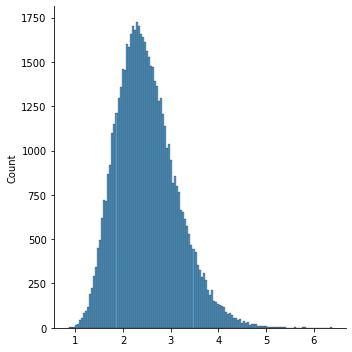

In [26]:
sns.displot(thickness.numpy())

## Generate thickness from intensity

In [27]:
gm = Gamma(10., 550.)

counts = np.array([110 * pyro.sample('t', gm) + 0.5 for i in range(60000)])

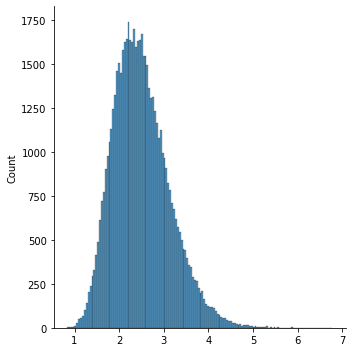

In [28]:
sns.displot(counts)

In [29]:
morphology_data.thickness.describe()

count    60000.000000
mean         2.503249
std          0.631763
min          0.875985
25%          2.048362
50%          2.434765
75%          2.888612
max          6.255515
Name: thickness, dtype: float64

In [30]:
# sns.displot(counts_thickness)

In [31]:
from collections import Counter

mode = Counter(morphology_data.intensity.astype('int')).most_common(1)[0][0]

In [32]:
intensity_sample_counts = Counter()

correction = morphology_data.intensity.median() + mode
correction /= 2

In [33]:
def thickness_dist(intensity, samples):
    with pyro.plate('obs', samples):
        rate = 5 * (intensity / correction)
        shape = 10  # * (intensity / correction)
        gamma = Gamma(shape, rate)
    return pyro.sample("thickness", gamma) + 0.5

In [34]:
samples = thickness_dist(torch.Tensor(intensity_samples[:60000]), 60000)

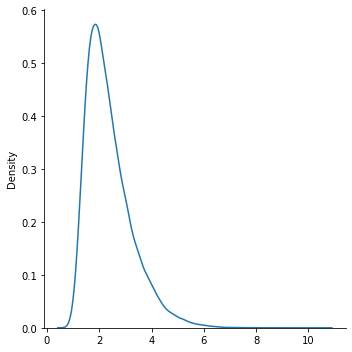

In [35]:
thickness_sample_counts = Counter(samples.numpy().round(2))
sns.displot(samples, kind='kde')

## Generate labels

<BarContainer object of 10 artists>

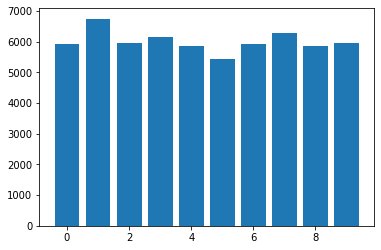

In [36]:
labels = Counter(morphology_data.label)
plt.bar(labels.keys(), labels.values())

In [37]:
label_counts = np.array(sorted(list(labels.items())))
label_counts

array([[   0, 5923],
       [   1, 6742],
       [   2, 5958],
       [   3, 6131],
       [   4, 5842],
       [   5, 5421],
       [   6, 5918],
       [   7, 6265],
       [   8, 5851],
       [   9, 5949]])

In [38]:
torch.Tensor(label_counts[:, 1] / morphology_data.shape[0])

tensor([0.0987, 0.1124, 0.0993, 0.1022, 0.0974, 0.0904, 0.0986, 0.1044, 0.0975,
        0.0992])

In [39]:
labels_dist = Categorical(torch.Tensor(label_counts[:, 1] / morphology_data.shape[0]))

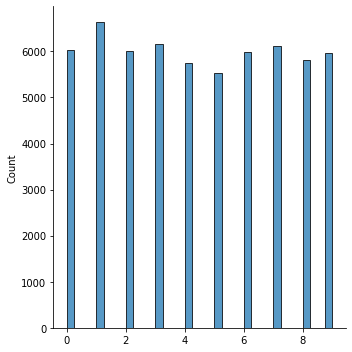

In [40]:
labels_samples = np.array([pyro.sample('labels', labels_dist) for i in range(60000)])
sns.displot(labels_samples)
plt.show()

## Full Data Generating Process

In [41]:
def model(n_samples=60000):
    with pyro.plate('observations', n_samples):
        intensity_transform = ComposeTransform([
            SigmoidTransform(),
            AffineTransform(66., 190.)]
        )
        
        normal_noise = pyro.sample('intensity_noise_normal', Normal(0, 1))
        gamma_noise = pyro.sample('intensity_noise_gamma', Gamma(10, 5))
        intensity_noise = 0.5 * normal_noise + 2 * gamma_noise - 4
        intensity = intensity_transform(intensity_noise)
        
        # thickness_transform = ComposeTransform([
        #     AffineTransform(-66/(190-66), 1/(190-66)),
        #     SigmoidTransform().inv,
        # ])
        
        # thickness_noise = pyro.sample('thickness_noise', Normal(0, 1))
        # thickness = (thickness_transform(intensity) + 5 - thickness_noise * 0.5) / 2
        
        noise = pyro.sample('thickness_noise', Normal(0, 1))
        # _i = intensity_transform.inv(intensities) 
        _i = (intensity - 66) / 190
        thickness = (-torch.log((1 / _i) - 1) + 5 - 0.5 * noise) / 2
        
        image_class_probs = [0.0987, 0.1124, 0.0993, 0.1022, 0.0974,
                             0.0904, 0.0986, 0.1044, 0.0975, 0.0992]
        labels = pyro.sample('labels', Categorical(torch.Tensor(image_class_probs)))
        
    return intensity, thickness, labels

<Figure size 720x720 with 0 Axes>

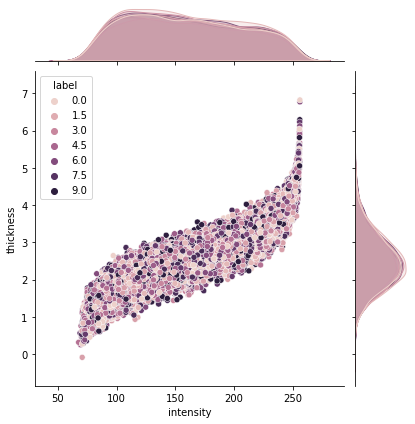

In [42]:
intensity, thickness, labels = model(60000)

generated_dataset = torch.stack([intensity, thickness, labels]).t().numpy()
generated_df = pd.DataFrame(generated_dataset, columns=['intensity', 'thickness', 'label'])

plt.figure(figsize=(10, 10))

sns.jointplot(data=generated_df, x="intensity", y="thickness", hue="label")
plt.show()

## Approximating I --> T with Conditional Normalising Flows

In [43]:
from pyro.distributions.transforms import Spline, ComposeTransformModule, ExpTransform, AffineTransform
from pyro.distributions import Uniform, Normal

from deepscm.distributions.transforms.affine import LearnedAffineTransform 

### NF for Intensity (without conditioning)

/vol/bitbucket/rrr2417/deepscm/ENV/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/vol/bitbucket/rrr2417/deepscm/ENV/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


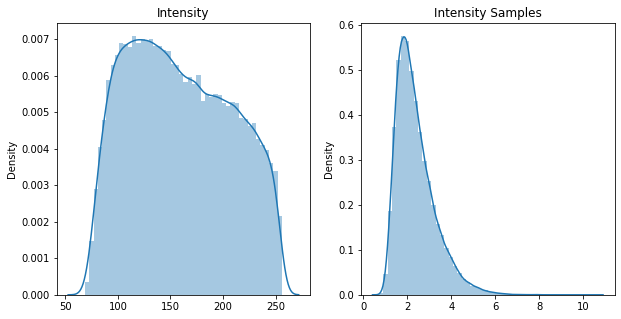

In [45]:
dataset = model(60000)

# (intensity, thickness)
stacked_dataset = torch.stack(dataset[:2]).t()

plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
sns.distplot(stacked_dataset[:, 0])
plt.title('Intensity')

plt.subplot(1, 2, 2)
plt.title('Intensity Samples')
sns.distplot(samples.detach().numpy())

plt.show()

In [46]:
dataset = stacked_dataset[:, 0].view(-1, 1)
dataset = dataset.to(device=device)

loc = dataset.min()
scale = dataset.max() - loc

mu = torch.zeros(1).to(device)
var = torch.ones(1).to(device)
base_dist = Normal(mu, var)

spline_transform = ComposeTransformModule([
    LearnedAffineTransform(),
    Spline(1, count_bins=8),
])
spline_transform = spline_transform.to(device)
constraint_transforms = ComposeTransform([
    SigmoidTransform(),
    AffineTransform(loc=loc, scale=scale),
])

# Effectively applied change of variables rule
flow_dist = TransformedDistribution(base_dist, [spline_transform, constraint_transforms])

In [47]:
spline_transform.load_state_dict(torch.load('spline_transform.pt'))

<All keys matched successfully>

In [48]:
# optimizer = torch.optim.Adam(spline_transform.parameters(), lr=1e-4)
# steps = 10000

# for step in range(steps):
#     optimizer.zero_grad()
#     loss = -flow_dist.log_prob(dataset).mean()
#     loss.backward()
#     optimizer.step()
#     flow_dist.clear_cache()
    
#     if step % 1000 == 0:
#         print('step: {}, loss: {}'.format(step, loss.item()))

# torch.save(spline_transform.state_dict(), 'spline_transform.pt')

In [49]:
intensity_data = dataset.cpu()
intensity_samples = flow_dist.sample([10000]).cpu().detach().numpy()

/vol/bitbucket/rrr2417/deepscm/ENV/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/vol/bitbucket/rrr2417/deepscm/ENV/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


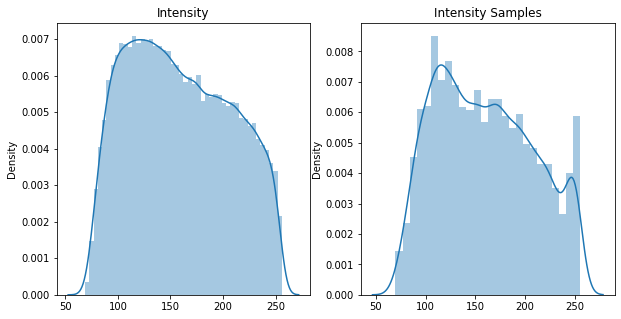

In [50]:
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.title('Intensity')
sns.distplot(intensity_data)

plt.subplot(1, 2, 2)
plt.title('Intensity Samples')
sns.distplot(intensity_samples)

plt.show()

In [51]:
norm_samples = [constraint_transforms.inv(flow_dist.sample()).cpu() for x in range(10000)]

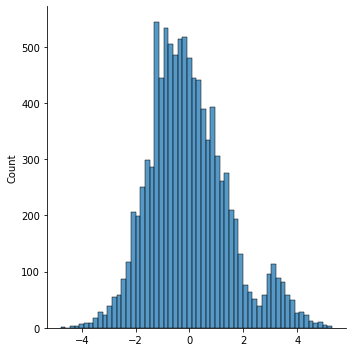

In [52]:
_norm_samples = [x.item() for x in norm_samples]
sns.displot(_norm_samples)

### NF for thickness (without conditioning)

In [53]:
thickness = stacked_dataset[:, 1].view(-1, 1)
thickness = thickness.to(device=device)

lognorm_loc = thickness.log().mean().float()
lognorm_scale = thickness.log().std().float()

thickness_base_dist = Normal(
    torch.zeros(1).to(device),
    torch.ones(1).to(device)
)

thickness_transform = ComposeTransformModule([
    Spline(1, count_bins=5),
])
thickness_transform = thickness_transform.to(device)
thickness_constraint_transforms = ComposeTransform([
    AffineTransform(loc=lognorm_loc, scale=lognorm_scale),
    ExpTransform(),
])

thickness_flow_dist = TransformedDistribution(
    thickness_base_dist,
    [thickness_transform, thickness_constraint_transforms]
)

In [54]:
lognorm_loc, lognorm_scale

(tensor(0.8710, device='cuda:0'), tensor(0.3094, device='cuda:0'))

In [55]:
thickness_transform.load_state_dict(torch.load('thickness_spline_transform.pt'))

<All keys matched successfully>

In [56]:
# optimizer = torch.optim.Adam(thickness_transform.parameters(), lr=1e-4)
# steps = 10000

# for step in range(steps):
#     optimizer.zero_grad()
#     loss = -thickness_flow_dist.log_prob(thickness).mean()
#     loss.backward()
#     optimizer.step()
#     thickness_flow_dist.clear_cache()
    
#     if step % 1000 == 0:
#         print('step: {}, loss: {}'.format(step, loss.item()))

# torch.save(thickness_transform.state_dict(), 'thickness_spline_transform.pt')

/vol/bitbucket/rrr2417/deepscm/ENV/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/vol/bitbucket/rrr2417/deepscm/ENV/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


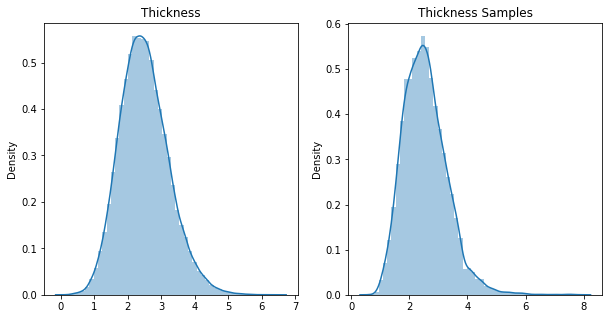

In [57]:
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.title('Thickness')
sns.distplot(thickness.cpu())

thickness_samples = thickness_flow_dist.sample([10000]).cpu().detach().numpy()

plt.subplot(1, 2, 2)
plt.title('Thickness Samples')
sns.distplot(thickness_samples)

plt.show()

### Thickness | Intensity - NF with conditioning

In [58]:
from pyro.distributions.conditional import ConditionalTransformedDistribution
from deepscm.distributions.transforms.affine import ConditionalAffineTransform
from pyro.nn import DenseNN

In [59]:
# dataset = stacked_dataset[:, 0].view(-1, 1)
# dataset = dataset.to(device=device)

# loc = dataset.min()
# scale = dataset.max() - loc

# mu = torch.zeros(1).to(device)
# var = torch.ones(1).to(device)
# base_dist = Normal(mu, var)

# spline_transform = ComposeTransformModule([
#     LearnedAffineTransform(),
#     Spline(1, count_bins=8),
# ])
# spline_transform = spline_transform.to(device)
# constraint_transforms = ComposeTransform([
#     SigmoidTransform(),
#     AffineTransform(loc=loc, scale=scale),
# ])

# # Effectively applied change of variables rule
# flow_dist = TransformedDistribution(base_dist, [spline_transform, constraint_transforms])

In [60]:
from pyro.distributions.transforms import conditional_spline, ConditionalSpline, conditional_spline_autoregressive, ConditionalPlanar
from deepscm.distributions.transforms.affine import ConditionalAffineTransform

In [61]:
import random

torch.backends.cudnn.benchmark = False
seed = 40
np.random.seed(seed)
random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)

In [122]:
# thickness_net = DenseNN(
#     input_dim=1,
#     hidden_dims=[1],
#     param_dims=[1, 1],
#     nonlinearity=torch.nn.ReLU()
# )

# print(thickness_net.state_dict())

# thickness_c_flow = ConditionalAffineTransform(
#     context_nn=thickness_net,
#     event_dim=0
# ).to(device)

# thickness_c_flow = ConditionalSpline(
#     thickness_net,
#     input_dim=1,
#     count_bins=5,
#     order='quadratic',
# ).to(device)

thickness_c_flow = conditional_spline(1, 1, count_bins=8, hidden_dims=[1, 1], bound=1, order='linear').to(device)

thickness_c_flow_constraint = ComposeTransform([
    SigmoidTransform(),
    AffineTransform(loc=lognorm_loc, scale=lognorm_scale),
])
thickness_c_flow_transforms = [
    SigmoidTransform(),
    thickness_c_flow,
    SigmoidTransform().inv,
    LearnedAffineTransform().to(device), # Change to conditional learned affine
#     AffineTransform(loc=lognorm_loc, scale=lognorm_scale),
#     thickness_c_flow_constraint,
]

# Try conditional planar flow

# intensity_sample = flow_dist.sample()
# intensity_ = constraint_transforms.inv(intensity_sample)

thickness_c_dist = ConditionalTransformedDistribution(
    thickness_base_dist,
    thickness_c_flow_transforms
)

optimizer = torch.optim.Adam(thickness_c_flow.parameters(), lr=5e-3)
steps = 10000

data_size = 60000

for step in range(steps):
    optimizer.zero_grad()
    
    thickness_log_prob_cond = thickness_c_dist \
        .condition(dataset[:data_size].detach()) \
        .log_prob(thickness[:data_size].detach())
    
    loss = -thickness_log_prob_cond.mean()
    loss.backward()
    
    optimizer.step()
    
    thickness_c_dist.clear_cache()
    
    if step % 1000 == 0:
        print('step: {}, loss: {}'.format(step, loss.item()))

step: 0, loss: 38.51474380493164
step: 1000, loss: 1.1237956285476685
step: 2000, loss: 1.0981721878051758
step: 3000, loss: 1.092889666557312
step: 4000, loss: 1.0910272598266602
step: 5000, loss: 1.090049147605896
step: 6000, loss: 1.0892760753631592
step: 7000, loss: 1.0888183116912842
step: 8000, loss: 1.0887327194213867
step: 9000, loss: 1.088698148727417


/vol/bitbucket/rrr2417/deepscm/ENV/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/vol/bitbucket/rrr2417/deepscm/ENV/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


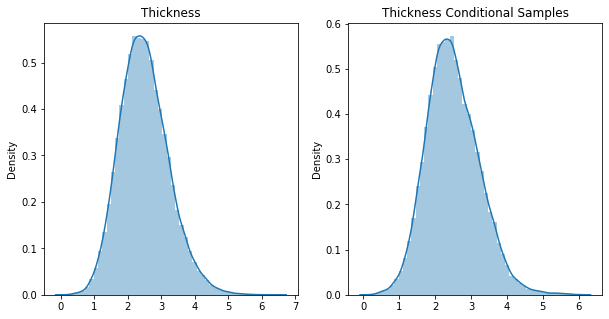

In [123]:
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.title('Thickness')
sns.distplot(thickness[:60000].cpu())

t_samples = 60000
thickness_c_samples = thickness_c_dist.condition(dataset[:t_samples]).sample([t_samples]).cpu().detach().numpy()

plt.subplot(1, 2, 2)
plt.title('Thickness Conditional Samples')
sns.distplot(thickness_c_samples)

plt.show()

/vol/bitbucket/rrr2417/deepscm/ENV/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/vol/bitbucket/rrr2417/deepscm/ENV/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


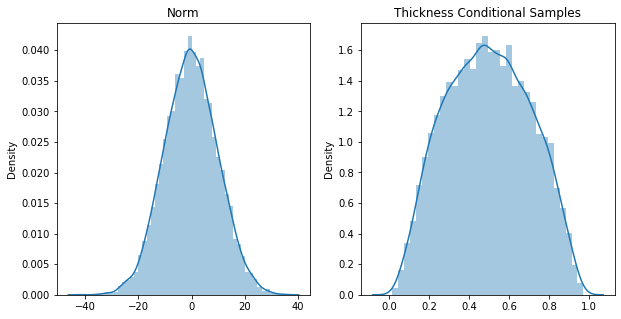

In [124]:
n = Normal(0, 10)

samples = n.sample([10000])

sigm = 1 / (1 + np.exp(-(samples * 0.1)))

plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.title('Norm')
sns.distplot(samples)

plt.subplot(1, 2, 2)
plt.title('Thickness Conditional Samples')
sns.distplot(sigm)

plt.show()

### Visualising P(thickness | intensity) not trained jointly

In [125]:
_intensity_samples = flow_dist.sample([10000])
conditional_thickness_samples = thickness_c_dist.condition(_intensity_samples).sample([10000])


# generated_dataset = torch.cat([_intensity_samples, conditional_thickness_samples]).cpu().t().numpy()
# generated_df = pd.DataFrame(generated_dataset, columns=['intensity', 'thickness'])

# plt.figure(figsize=(10, 10))

# sns.jointplot(data=generated_df, x="intensity", y="thickness")
# plt.show()

In [126]:
_intensity_samples.shape, conditional_thickness_samples.shape

(torch.Size([10000, 1]), torch.Size([10000, 1]))

In [127]:
generated_res = torch.transpose(
    torch.stack([_intensity_samples, conditional_thickness_samples]), 0, 1
).squeeze(-1).cpu().numpy()
generated_res_df = pd.DataFrame(generated_res, columns=['intensity', 'thickness'])

generated_res_df.head()

,intensity,thickness
0,233.637573,1.933967
1,226.540100,2.549453
2,173.702850,4.061107
3,249.200409,3.589644
4,218.151489,1.676479


<Figure size 720x720 with 0 Axes>

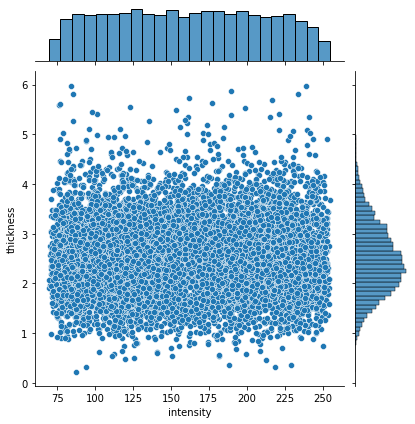

In [128]:
plt.figure(figsize=(10, 10))

sns.jointplot(data=generated_res_df, x="intensity", y="thickness")
plt.show()

### P(thickness | intensity) joint training

In [129]:
intensity_data = stacked_dataset[:, 0].view(-1, 1)
intensity_data = intensity_data.to(device=device)

loc = intensity_data.min()
scale = intensity_data.max() - loc

mu = torch.zeros(1).to(device)
var = torch.ones(1).to(device)
base_dist = Normal(mu, var)

spline_transform = ComposeTransformModule([
    LearnedAffineTransform(),
    # Spline(1, count_bins=8),
])
spline_transform = spline_transform.to(device)
constraint_transforms = ComposeTransform([
    SigmoidTransform(),
    AffineTransform(loc=loc, scale=scale),
])

# Effectively applied change of variables rule
flow_dist = TransformedDistribution(base_dist, [spline_transform, constraint_transforms])

In [140]:
thickness_data = stacked_dataset[:, 1].view(-1, 1)
thickness_data = thickness_data.to(device=device)

#, hidden_dims=[1, 1]
thickness_c_flow = conditional_spline(1, 1, count_bins=8, bound=1).to(device)

thickness_flow_lognorm_loc = thickness_data.log().mean()
thickness_flow_lognorm_scale = thickness_data.log().std()

thickness_c_flow_comps = ComposeTransform([
    AffineTransform(loc=thickness_flow_lognorm_loc, scale=thickness_flow_lognorm_scale),
    SigmoidTransform(),
#     SigmoidTransform().inv
#     AffineTransform(loc=thickness_flow_lognorm_loc, scale=thickness_flow_lognorm_scale)
#     ExpTransform(),
#     thickness_affine, # Change to conditional learned affine
])

# thickness_c_flow_constraints = ComposeTransform([])
# thickness_c_flow_components = [thickness_c_flow_comps, thickness_c_flow_constraints]

thickness_base_dist = Normal(
    torch.zeros(1).to(device) + thickness_flow_lognorm_loc,
    torch.ones(1).to(device) * thickness_flow_lognorm_scale,
)

thickness_c_dist = ConditionalTransformedDistribution(
    thickness_base_dist,
    [thickness_c_flow_comps, thickness_c_flow, ComposeTransform([SigmoidTransform().inv])],
)

In [141]:
# thickness_c_flow_transforms.inv

In [142]:
data_size = 60000

idx = torch.randperm(data_size)
_thickness_data = thickness_data[idx]
_intensity_data = intensity_data[idx]

assert _thickness_data.shape == _intensity_data.shape

In [143]:
modules = torch.nn.ModuleList([spline_transform, thickness_c_flow])
optimizer = torch.optim.Adam(modules.parameters(), lr=1e-3)
steps = 1000

for step in range(steps):
    optimizer.zero_grad()
    
    intensity_log_prob = flow_dist.log_prob(_intensity_data)
    _latent_intensity = constraint_transforms.inv(_intensity_data)
    thickness_log_prob_cond = thickness_c_dist \
        .condition(_latent_intensity.detach()) \
        .log_prob(_thickness_data.detach())
    
    loss = -(thickness_log_prob_cond + intensity_log_prob).mean()
    loss.backward()
    
    optimizer.step()
    
    flow_dist.clear_cache()
    thickness_c_dist.clear_cache()
    
    if step % 100 == 0:
        print('step: {}, loss: {}'.format(step, loss.item()))

step: 0, loss: 152.13412475585938
step: 100, loss: 21.129745483398438
step: 200, loss: 6.124698638916016
step: 300, loss: 5.486443519592285
step: 400, loss: 5.408573150634766
step: 500, loss: 5.368635654449463
step: 600, loss: 5.345393657684326
step: 700, loss: 5.329823017120361
step: 800, loss: 5.316961288452148
step: 900, loss: 5.304960250854492


In [144]:
_intensity_samples = flow_dist.sample([60000])
_intensity_latent = constraint_transforms.inv(_intensity_samples)
conditional_thickness_samples = thickness_c_dist.condition(_intensity_latent).sample([60000])

generated_res = torch.transpose(
    torch.stack([_intensity_samples, conditional_thickness_samples]), 0, 1
).squeeze(-1).cpu().numpy()
generated_res_df = pd.DataFrame(generated_res, columns=['intensity', 'thickness'])

generated_res_df.head()

,intensity,thickness
0,151.283691,2.514417
1,146.620667,2.357922
2,140.969101,2.321802
3,119.835014,2.679273
4,168.644043,2.943415


<Figure size 720x720 with 0 Axes>

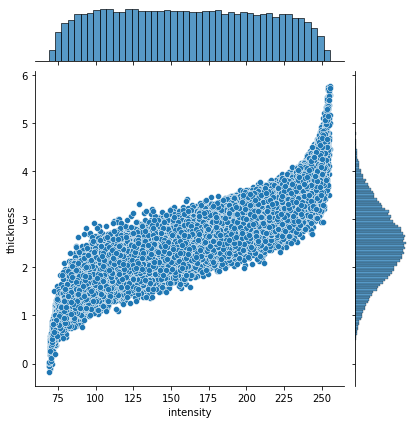

In [145]:
plt.figure(figsize=(10, 10))

sns.jointplot(data=generated_res_df, x="intensity", y="thickness")
plt.show()